In [1]:
import sys
dirname = '/Users/muhammaddaffarobani/Documents/personal_research/smt'
if dirname not in sys.path:
    sys.path.append(dirname)

import pandas as pd
import numpy as np
from smt.surrogate_models import KRG
from smt.problems import WingWeight
from smt.sampling_methods import LHS
from sklearn.metrics import mean_squared_error


from smt.explainability_tools import PartialDependenceDisplay, PDFeatureImportanceDisplay
from smt.explainability_tools import partial_dependence, pd_feature_importance

import matplotlib.pyplot as plt


In [2]:
ndoe = 200 
fun = WingWeight()
sampling = LHS(xlimits=fun.xlimits, criterion='ese', random_state=1)
X = sampling(ndoe)
y = fun(X)

n_train = int(0.8*ndoe)

X_tr, y_tr = X[:n_train, :], y[:n_train]
X_te, y_te = X[n_train:, :], y[n_train:]

In [3]:
kriging_model = KRG(
    theta0=[1e-2]*X_tr.shape[1],
    print_prediction = False
    )
kriging_model.set_training_values(
    X_tr, 
    y_tr
    )

kriging_model.train()
y_pred = kriging_model.predict_values(X_te)
rmse = mean_squared_error(y_te, y_pred, squared=False)
print(f"RMSE: {rmse:.4f}")


___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 160
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  3.4847879
RMSE: 0.3224


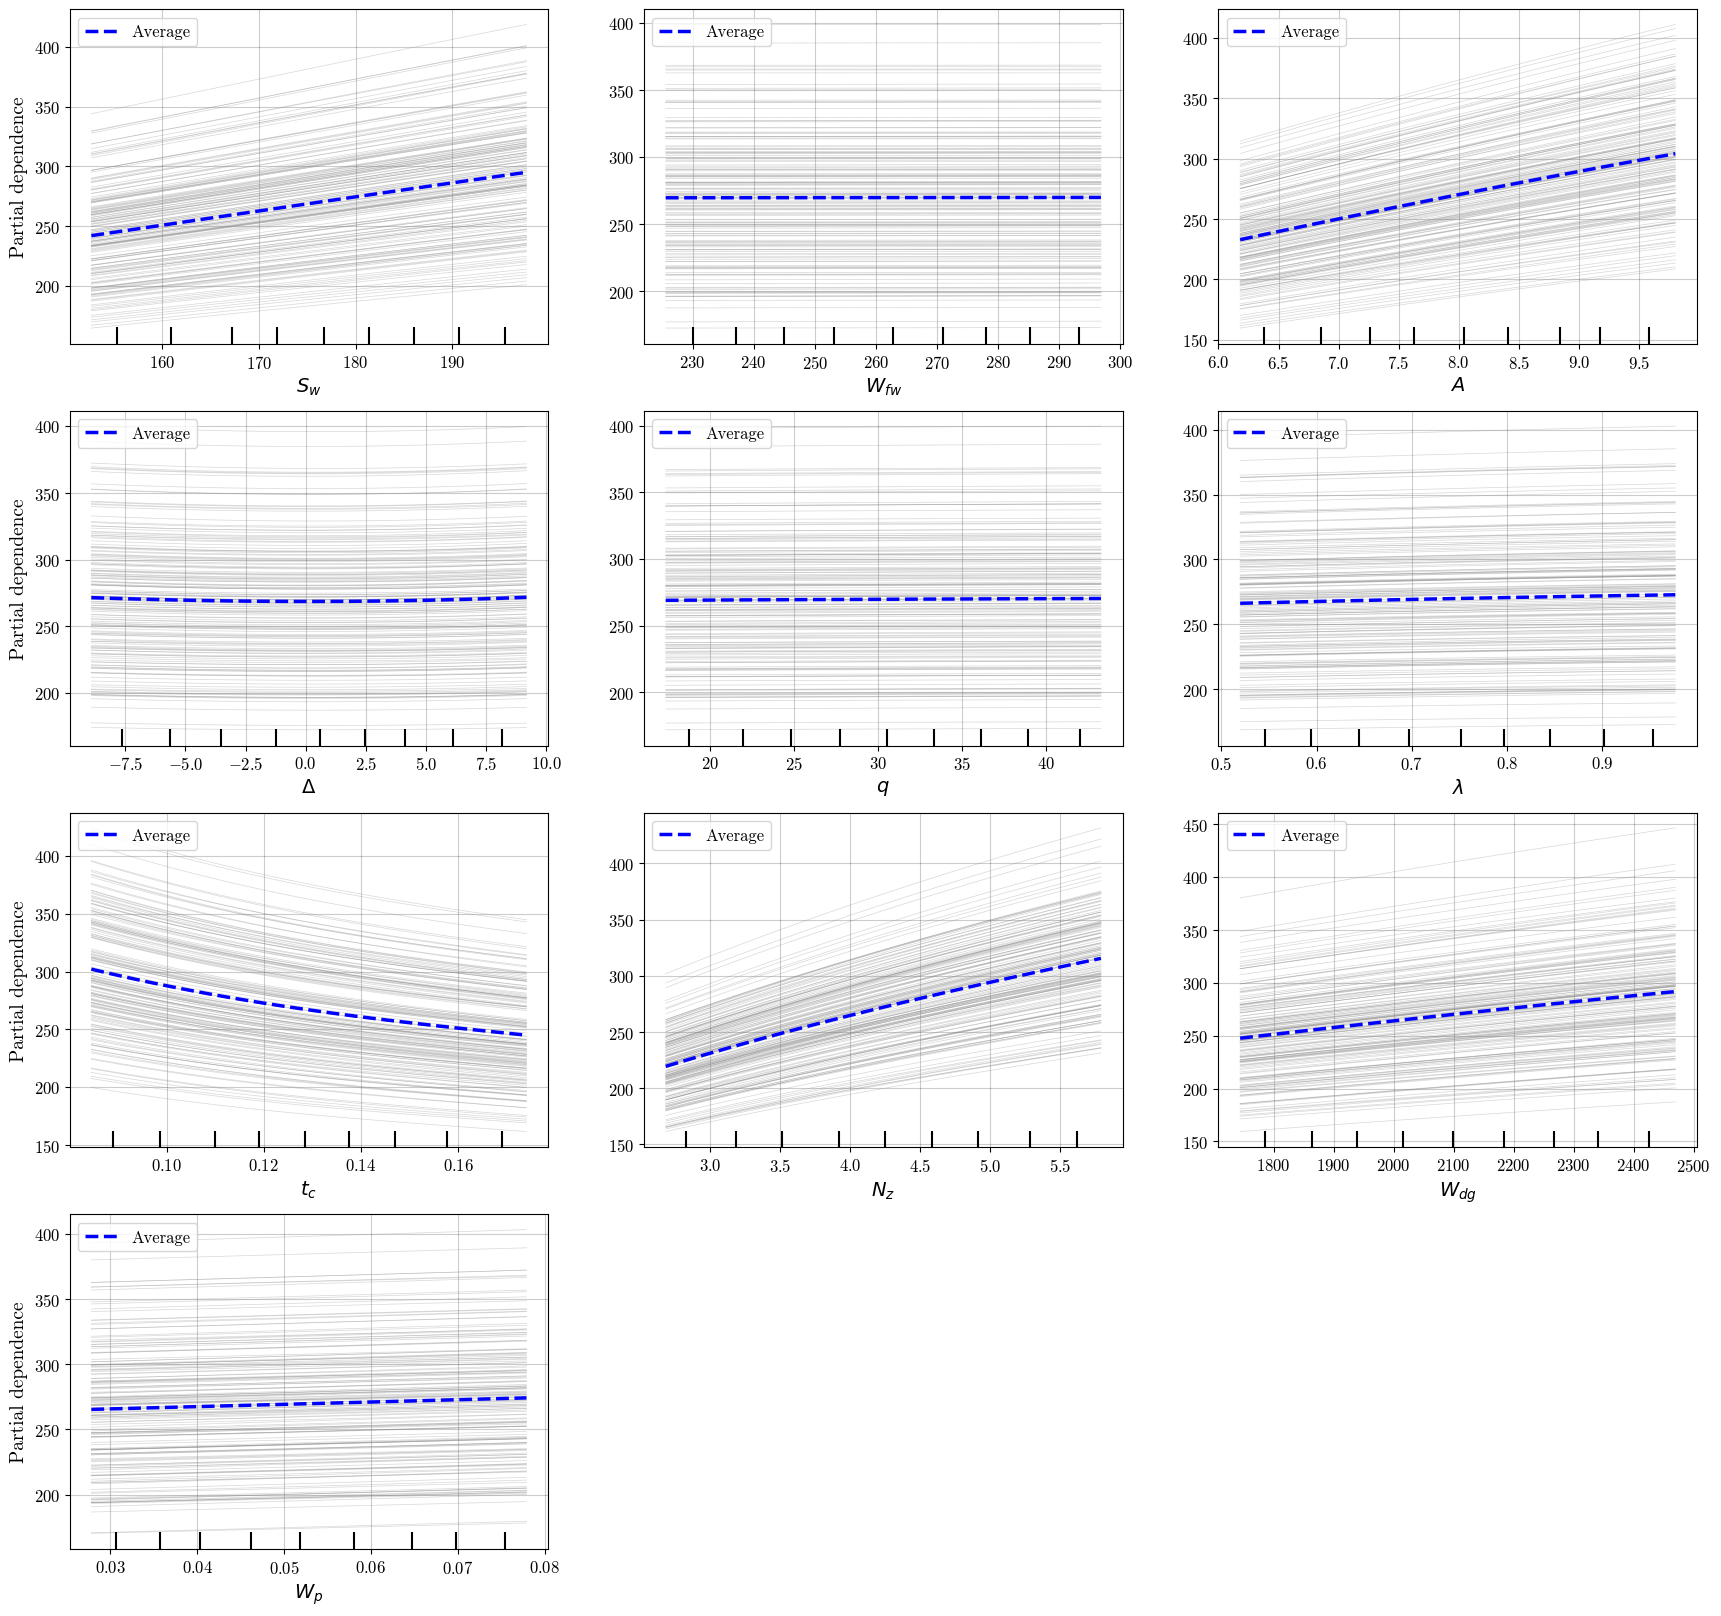

In [4]:
model = kriging_model
features = [
    0, 
    1, 
    2, 
    3, 
    4, 
    5, 
    6, 
    7, 
    8, 
    9,
]
feature_names = [
    r'$S_{w}$', 
    r'$W_{fw}$', 
    r'$A$', 
    r'$\Delta$', 
    r'$q$', 
    r'$\lambda$', 
    r'$t_{c}$',
    r'$N_{z}$', 
    r'$W_{dg}$', 
    r'$W_{p}$',
]
pdd = PartialDependenceDisplay.from_surrogate_model(
    model, 
    X_tr, 
    features, 
    grid_resolution=100, 
    kind='both',
    feature_names=feature_names,
    centered=False
    )

In [5]:
pdd.pd_results[0]["individual"].shape

(160, 100)

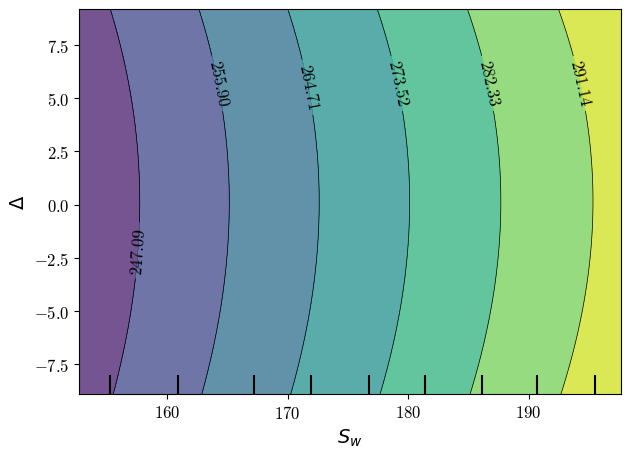

In [6]:
model = kriging_model
features = [
    (0, 3),
]
feature_names = [
    r'$S_{w}$', 
    r'$W_{fw}$', 
    r'$A$', 
    r'$\Delta$', 
    r'$q$', 
    r'$\lambda$', 
    r'$t_{c}$',
    r'$N_{z}$', 
    r'$W_{dg}$', 
    r'$W_{p}$',
]
pdd = PartialDependenceDisplay.from_surrogate_model(
    model, 
    X_tr, 
    features, 
    grid_resolution=100, 
    kind='both',
    feature_names=feature_names,
    centered=False
    )

In [7]:
pdd.pd_results[0]["individual"].shape

(160, 100, 100)

In [8]:
pdd.pd_results[0]["average"].shape

(100, 100)

In [43]:
# pairwise interaction
i = 0
j = 3
model = kriging_model
features = [
    i, 
    j, 
    (i, j),
]
pd_results = partial_dependence(
    model, 
    X_tr, 
    features,
    method="sample",
)

average_i = pd_results[0]["average"]
average_j = pd_results[1]["average"]
average_ij = pd_results[2]["average"]

# average_i = (average_i - np.std(average_i)) / np.mean(average_i)
# average_j = (average_j - np.std(average_j)) / np.mean(average_j)
# average_ij = (average_ij - np.std(average_ij)) / np.mean(average_ij)



numerator = average_ij - average_i - average_j
numerator = (numerator ** 2).sum()
denominator = (average_ij**2).sum()
numerator / denominator

0.995772320666688

In [65]:
# overall interaction
i = 8
model = kriging_model
features = [
    i, 
    [j for j in range(X.shape[1]) if j != i],
]
pd_results = partial_dependence(
    model, 
    X_tr, 
    features,
    method="sample",
)

average_i = pd_results[0]["average"]
average_other = pd_results[1]["average"]
y_pred = model.predict_values(X_tr)
y_pred = y_pred.reshape(-1, )

# average_i = (average_i - np.std(average_i)) / np.mean(average_i)
# average_j = (average_j - np.std(average_j)) / np.mean(average_j)
# average_ij = (average_ij - np.std(average_ij)) / np.mean(average_ij)



numerator = y_pred - average_i - average_other
numerator = (numerator ** 2).sum()
denominator = (y_pred**2).sum()
numerator / denominator

0.9739117839496558

In [70]:
X_tr[np.random.choice(X_tr.shape[0], size=100, replace=False)].shape

(100, 10)

In [25]:
# def cartesian(arrays, out=None):
#     """Generate a cartesian product of input arrays.

#     Parameters
#     ----------
#     arrays : list of array-like
#         1-D arrays to form the cartesian product of.
#     out : ndarray of shape (M, len(arrays)), default=None
#         Array to place the cartesian product in.

#     Returns
#     -------
#     out : ndarray of shape (M, len(arrays))
#         Array containing the cartesian products formed of input arrays.
#         If not provided, the `dtype` of the output array is set to the most
#         permissive `dtype` of the input arrays, according to NumPy type
#         promotion.

#         .. versionadded:: 1.2
#            Add support for arrays of different types.

#     Notes
#     -----
#     This function may not be used on more than 32 arrays
#     because the underlying numpy functions do not support it.

#     Examples
#     --------
#     >>> from sklearn.utils.extmath import cartesian
#     >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
#     array([[1, 4, 6],
#            [1, 4, 7],
#            [1, 5, 6],
#            [1, 5, 7],
#            [2, 4, 6],
#            [2, 4, 7],
#            [2, 5, 6],
#            [2, 5, 7],
#            [3, 4, 6],
#            [3, 4, 7],
#            [3, 5, 6],
#            [3, 5, 7]])
#     """
#     arrays = [np.asarray(x) for x in arrays]
#     shape = (len(x) for x in arrays)

#     ix = np.indices(shape)
#     ix = ix.reshape(len(arrays), -1).T

#     if out is None:
#         dtype = np.result_type(*arrays)  # find the most permissive dtype
#         if dtype.str[:2] != '<U':
#             out = np.empty_like(ix, dtype=dtype)
#         else:
#             out = np.empty_like(ix, dtype='object')

#     for n, arr in enumerate(arrays):
#         out[:, n] = arrays[n][ix[:, n]]

#     return out

In [26]:
# def non_cartesian(arrays, out=None):
#     arrays = [np.asarray(x) for x in arrays]
    
#     ref = np.zeros((len(arrays[0]), len(arrays)))
#     if out is None:
#         out = np.empty_like(ref, dtype="object")

#     for n, array in enumerate(arrays):
#         out[:, n] = array
#     return out


In [27]:
# arrays = [[0, 1, 2], ["a", "h", "c"]]
# arrays = [[0, 1, ], ["a", "h", "c"]]
# non_cartesian(arrays)